# Test of SciNet with a force pendulum

### Creation of synthetic data for force pendulum + damping + little angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

import gc

from physical_parameters_SciNet.model_instances.n1_setting_synthetic_forced_damped_pendulum import config



Choosen device = cuda


#### One damped forced pendulum with a constant forcing

In [2]:
def create_synthetic_damped_forced_pendulum(A: float, omega: float, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation.

    Parameters:
    A (float): Amplitude of the forcing term.
    omega (float): Frequency of the forcing term.
    beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
    kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
    theta0 (float): Initial angle (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    t (numpy array): Time array.

    Returns:
    numpy array: Array of angles at each time step.
    """

    def pendulum_ode(t, y):
        theta, omega_t = y
        dtheta_dt = omega_t
        domega_dt = - beta * omega_t - kapa * theta + A * np.cos(omega * t)
        return [dtheta_dt, domega_dt]

    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t)
    
    return sol.y[0]  # Return only the angle array

In [3]:
A = 1.0
omega = 3.0
beta = 0.2
kapa = 3.0
theta0 = 0.9  # Initial angle in radians
omega0 = 0.0  # Initial angular velocity
t = np.linspace(0, 100, 10000)  # Time from 0 to 10 seconds

y = create_synthetic_damped_forced_pendulum(A, omega, beta, kapa, theta0, omega0, t)

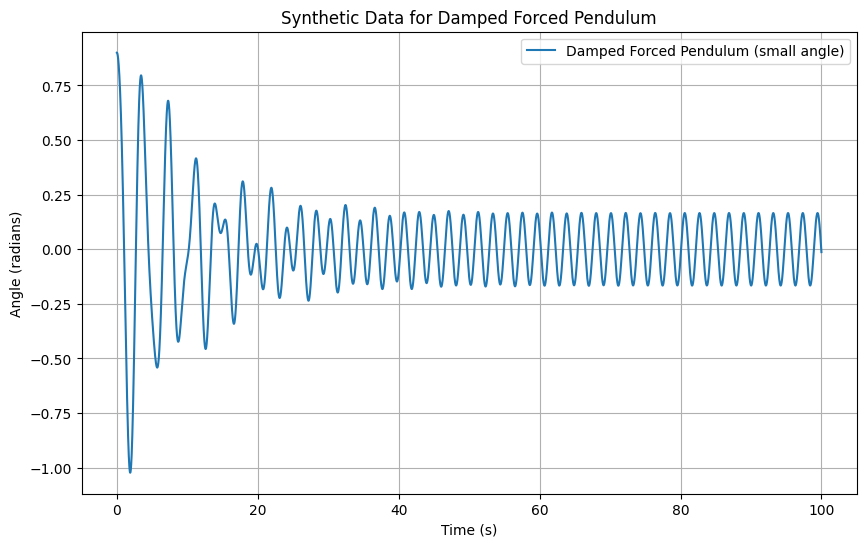

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Damped Forced Pendulum (small angle)')
plt.title('Synthetic Data for Damped Forced Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

#### Create complexe profil of forcing

-> trapezoidale shape

In [5]:
def create_trapezoidal_forcing(t: np.ndarray, start_value: float, end_value: float, proportions: list[float], N_time_steps: int) -> np.ndarray:
    """
    Create a trapezoidal forcing function.

    Args:
        t (numpy array): Time array.
        start_value (float): Initial value of the forcing.
        end_value (float): Value at the plateau of the trapezoid.
        proportions (list): List of 4 proportions [p1, p2, p3, p4] defining:
                        - from 0 to p1: constant value at start_value
                        - from p1 to p2: linear rise from start_value to end_value
                        - from p2 to p3: plateau at end_value
                        - from p3 to p4: linear fall from end_value to start_value
                        - from p4 to 1: constant value at start_value
        N_time_steps (int): Number of time steps. Theoretically len(t).

    Returns:
        array: Array of the trapezoidal forcing function.
    """
    assert len(t) == N_time_steps, "Length of time array must match N_time_steps"
    if len(proportions) != 4:
        raise ValueError("proportions must be a list of 4 values")

    p1, p2, p3, p4 = proportions
    if not (0 <= p1 <= p2 <= p3 <= p4 <= 1):
        raise ValueError("Proportions must be increasing and between 0 and 1")

    # Transition indices
    idx1 = int(p1 * N_time_steps)
    idx2 = int(p2 * N_time_steps)
    idx3 = int(p3 * N_time_steps)
    idx4 = int(p4 * N_time_steps)

    # Initialize the array
    omega_array = np.ones(N_time_steps) * start_value

    # Phase 1: Linear rise (p1 to p2)
    if idx2 > idx1:
        slope_up = (end_value - start_value) / (t[idx2] - t[idx1])
        omega_array[idx1:idx2] = start_value + slope_up * (t[idx1:idx2] - t[idx1])

    # Phase 2: Plateau (p2 to p3)
    omega_array[idx2:idx3] = end_value

    # Phase 3: Linear fall (p3 to p4)
    if idx4 > idx3:
        slope_down = (start_value - end_value) / (t[idx4] - t[idx3])
        omega_array[idx3:idx4] = end_value + slope_down * (t[idx3:idx4] - t[idx3])
    
    return omega_array

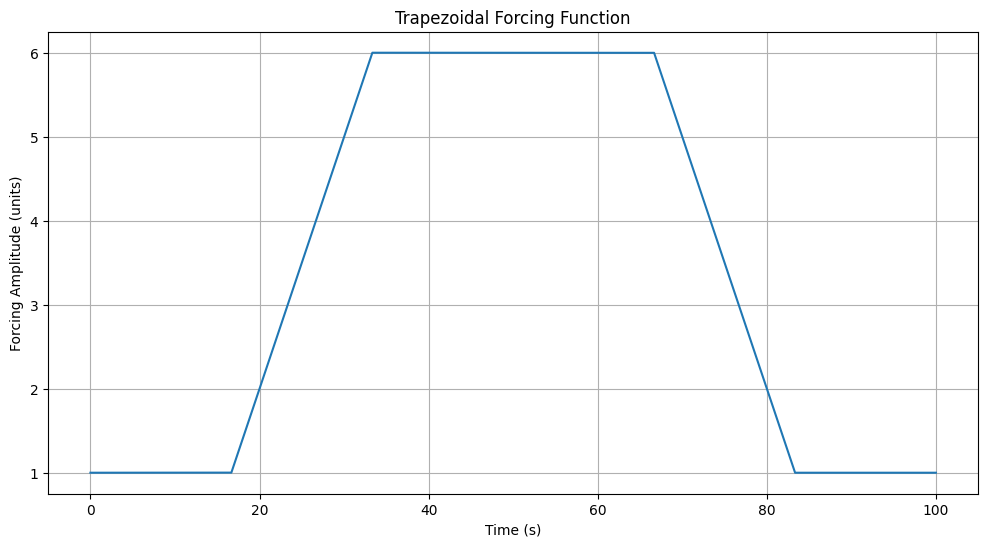

In [6]:
N_time_steps = 100000
t = np.linspace(0, 100, N_time_steps)

omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)

plt.figure(figsize=(12, 6))
plt.plot(t, omega_array)
plt.xlabel('Time (s)')
plt.ylabel('Forcing Amplitude (units)')
plt.title('Trapezoidal Forcing Function')
plt.grid(True)
plt.show()

#### Create pendulum with trapezoidal forcing

In [7]:
def create_synthetic_damped_forced_pendulum(A_array: np.ndarray, omega_array: np.ndarray, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation
    and time-varying forcing frequency.

    Args:
        A (numpy array): Amplitude of the forcing term (time-varying).
        omega_array (numpy array): Array of forcing frequencies at each time step.
        beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
        kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).
        t (numpy array): Time array.

    Returns:
        numpy array: Array of angles at each time step.
    """
    # Check if omega_array has the same length as t
    if len(omega_array) != len(t):
        raise ValueError("omega_array must have the same length as t")
    # Check if A is constant or variable
    if len(A_array) != len(t):
        raise ValueError("If A is an array, it must have the same length as t")


    def pendulum_ode(t, y):
        # Find the index of the current time step
        idx = np.abs(t_array - t).argmin()
        
        theta, omega_t = y
        dtheta_dt = omega_t
        # Use the forcing value corresponding to the current time
        domega_dt = - beta * omega_t - kapa * theta + A_array[idx] * np.cos(omega_array[idx] * t)
        return [dtheta_dt, domega_dt]

    # Store the global time array for use in the ODE
    global t_array
    t_array = t.copy()
    
    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t, method='RK45')
    
    return sol.y[0]  # Return only the angle array

In [8]:
# Time array
N_time_steps = 2000
t = np.linspace(0, 100, N_time_steps)

# Variable pulsation (trapezoidal shape)
A_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=10.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)
# Variables amplitudes or not
omega_value = 1.0
omega_array = np.ones(N_time_steps) * omega_value
# Parameters
beta = 0.1
kapa = 10.0
theta0 = 1.0
omega0 = 0.0

y = create_synthetic_damped_forced_pendulum(A_array, omega_array, beta, kapa, theta0, omega0, t)

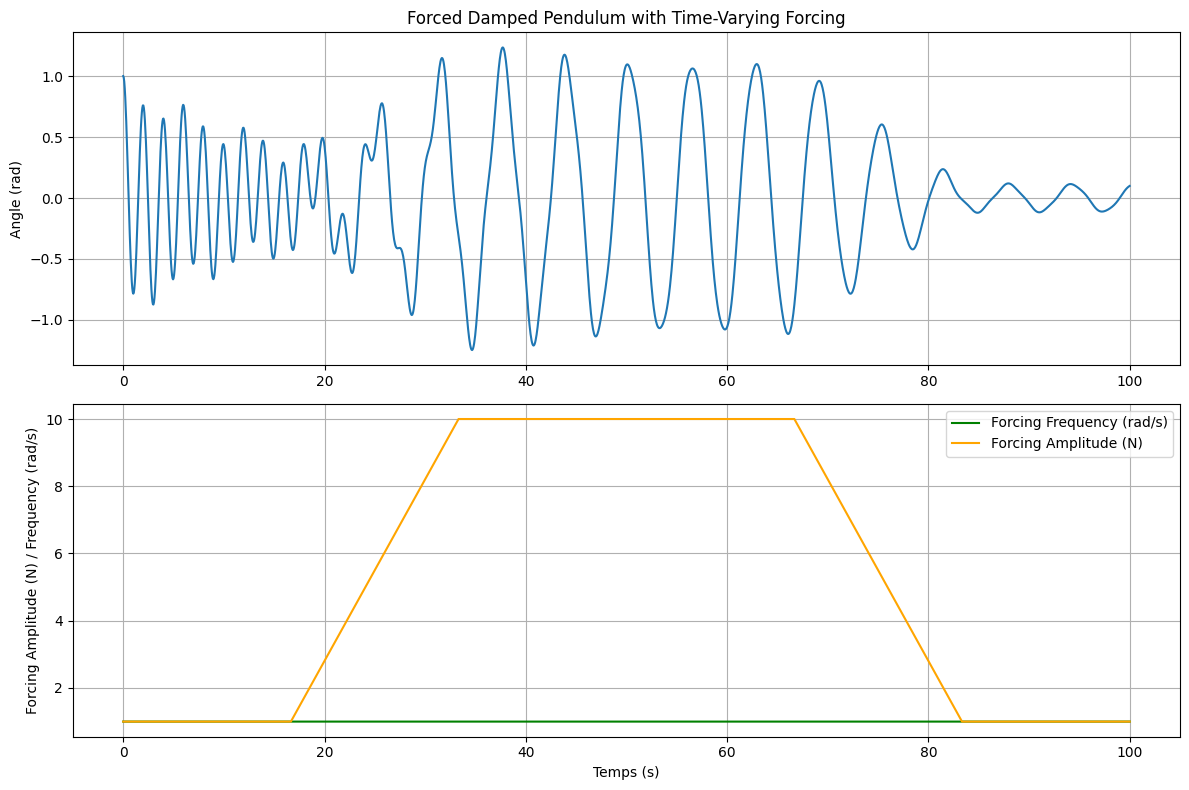

In [9]:
# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(t, y)
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Forced Damped Pendulum with Time-Varying Forcing')
ax1.grid(True)

ax2.plot(t, omega_array, color='green', label='Forcing Frequency (rad/s)')
ax2.plot(t, A_array, color='orange', label='Forcing Amplitude (N)')
ax2.set_ylabel('Forcing Amplitude (N) / Frequency (rad/s)')
ax2.set_xlabel('Temps (s)')
ax2.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Create Dataset of various parameters for differents forcing

* A: fixed
* theta0: fixed
* omega0: fixed
* kapa: varying randomly
* beta: varying randomly
* omega_forcing: choosen among a discret number


In [10]:
def create_dataset(
        N_sample: int, 
        maxtime: float, 
        n_timestep: int, 
        kapa_range: tuple, 
        beta_range: tuple, 
        trapezoidal_forcing_values: dict,
        A_value: float | None = 1.0,
        omega_value: float | None = 1.0,
        theta0: float = 0.5, 
        omega0: float = 0.0
    ):
    """
    Create a dataset of synthetic damped forced pendulum data with varying parameters.

    Args:
        N_sample (int): Number of samples to generate.
        maxtime (float): Maximum time for the simulation.
        n_timestep (int): Number of time steps in the simulation.
        kapa_range (tuple): Tuple defining the range of spring constants (min, max).
        beta_range (tuple): Tuple defining the range of damping coefficients (min, max).
        trapezoidal_forcing_values (dict): dictionary of args for the forcing parameters.
        A_value (float or None): Amplitude of the forcing term (constant or variable).
        omega_forcing_values (float or None): Pulsation of the forcing term (constant or variable).

    Parameters:
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).

    Returns:
        list: List of dictionaries containing parameters and corresponding angle arrays.
    """
    assert (A_value is not None) ^ (omega_value is not None), "Either A_value or omega_value must be provided as constant."

    dataset = []
    t = np.linspace(0, maxtime, n_timestep)

    for _ in tqdm(range(N_sample)):
        # Choose forcing frequency parameters
        trap_start, trap_end = 1.0, 0.0
        while trap_start >= trap_end:
            trap_start = np.random.uniform(*trapezoidal_forcing_values["start_value"])
            trap_end = np.random.uniform(*trapezoidal_forcing_values["end_value"])
        proportions = [np.random.uniform(*trapezoidal_forcing_values["proportions"][a]) for a in range(4)]
        trap_forcing_values_sampled = {
            "start_value": trap_start,
            "end_value": trap_end,
            "proportions": proportions
        }
        # Randomly choose a forcing frequency from the provided values
        if omega_value is not None:
            A_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            omega_forcing = np.ones(n_timestep) * omega_value
        else:
            omega_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            A_forcing = np.ones(n_timestep) * A_value

        # Randomly sample kapa and beta within their respective ranges
        kapa = np.random.uniform(*kapa_range)
        beta = np.random.uniform(*beta_range)

        # Create the synthetic data
        y = create_synthetic_damped_forced_pendulum(A_forcing, omega_forcing, beta, kapa, theta0, omega0, t)

        # Store the parameters and the resulting angle array
        sample = {
            'kapa': kapa,
            'beta': beta,
            'forcing': omega_forcing if omega_value is None else A_forcing,
            'time': t,
            'angle': y
        }
        
        dataset.append(sample)
    
    return dataset

In [11]:
eps = 1/13
trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
trapezoidal_forcing_ranges = {
    "start_value": (0.5, 2.0),
    "end_value": (1.0, 6.0),
    "proportions": trapezoid_range,
}

beta_range = config.BETA_RANGE
kapa_range = config.KAPA_RANGE
N_samples = config.N_SAMPLES
N_time_steps = config.TIMESTEPS
max_time = config.MAXTIME

dataset = create_dataset(
    N_sample=N_samples,
    maxtime=max_time,
    n_timestep=N_time_steps,
    kapa_range=kapa_range,
    beta_range=beta_range,
    trapezoidal_forcing_values=trapezoidal_forcing_ranges,
    A_value=config.A_VALUE,
    omega_value=config.OMEGA_VALUE,
    theta0=config.THETA0,
    omega0=config.OMEGA0
)

100%|██████████| 20000/20000 [08:00<00:00, 41.62it/s]


In [12]:
len(dataset)

20000

In [13]:
path = config.DIR_RAW_DATA / "synthetic_damped_forced_pendulum_dataset_3.npy"

# np.save(path, dataset)
dataset = np.load(path, allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ITER/brussel/Documents/ITER-physical-parameters-with-SciNet/data/raw/synthetic_damped_forced_pendulum_dataset_3.npy'

In [14]:
dataset[0]

{'kapa': 1.5227525095137953,
 'beta': 0.4397792655987208,
 'forcing': array([1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.0

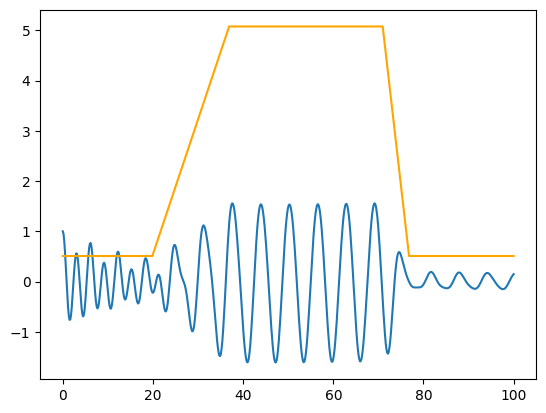

In [15]:
id_to_plot = 9
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['angle'])
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['forcing'], color='orange')
plt.show()

#### Create dataloader for SciNet

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [17]:
class forced_pendulum_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        observations = torch.tensor(sample['angle'], dtype=torch.float32)
        questions = torch.tensor(sample['forcing'], dtype=torch.float32)
        params = torch.tensor([sample['kapa'], sample['beta']], dtype=torch.float32)
        return observations, questions, params

In [18]:
split_ratio = config.SPLIT_RATIO  # Train, Validation, Test

train_size = int(split_ratio[0] * len(dataset))
val_size = int(split_ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

Dataset_custom = forced_pendulum_dataset(dataset)

train_dataset, val_dataset, test_dataset = random_split(Dataset_custom, [train_size, val_size, test_size])

In [19]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print("Types of datasets:", type(train_dataset), type(val_dataset), type(test_dataset))

Train size: 14000
Validation size: 3000
Test size: 3000
Types of datasets: <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [20]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)

#### Scinet network

In [21]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    

class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1000, 
                 output_size: int = 1000, 
                 hidden_sizes: list = [128, 128]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z


class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1000,
                 dec_hidden_sizes: list[int] = [128, 128], 
                 output_size: int = 1000
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


In [22]:
def scinet_loss_forced_pendulum(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.003
        ) -> torch.Tensor:

    recon_loss = torch.nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

#### Train scinet

In [23]:
from physical_parameters_SciNet.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [24]:
def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:

    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, _ in tqdm(train_loader, desc="Training", leave=False):
            a_corr = observations.clone()
            observations = observations.to(device)
            questions = questions.to(device)
            a_corr = a_corr.to(device)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, _ in tqdm(valid_loader, desc="Validation", leave=False):
                a_corr = observations.clone()
                observations = observations.to(device)
                questions = questions.to(device)
                a_corr = a_corr.to(device)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = config.DIR_PARAMS_CHECKPOINTS / "pendulum_scinet_checkpointed.pth"
        torch.save(model.state_dict(), path)

        del observations, questions, a_corr, possible_answer, mean, logvar, loss, l_kld, l_recon
        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [25]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = config.DIR_FIGURES / "training_validation_loss.png"
    plt.savefig(path)
    return None

In [26]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [27]:
### SCINET architecture
TIMESTEPS = config.TIMESTEPS  # 200
M_INPUT_SIZE = TIMESTEPS
M_ENC_HIDDEN_SIZES = config.M_ENC_HIDDEN_SIZES  # [500, 100] # [500, 100, 100]
M_LATENT_SIZE = config.M_LATENT_SIZE  # 3
M_QUESTION_SIZE = TIMESTEPS
M_DEC_HIDDEN_SIZES = config.M_DEC_HIDDEN_SIZES  # [500, 500] # [200, 200, 300]
M_OUTPUT_SIZE = TIMESTEPS

### Hyperparameters
BATCH_SIZE_TRAIN = config.BATCH_SIZE_TRAIN  # 50
BATCH_SIZE_VALID = config.BATCH_SIZE_EVAL  # 50
FIRST_LEARNING_RATE = config.FIRST_LEARNING_RATE  # 5e-4
WEIGHT_DECAY = config.WEIGHT_DECAY  # 1e-6
KLD_BETA = config.KLD_BETA  # 0.0003

### Train parameters
NUM_EPOCHS = config.NUM_EPOCHS  # 150
ES_PATIENCE = config.ES_PATIENCE  # 12
ES_MIN_DELTA = config.ES_MIN_DELTA  # 5e-4
GC_MAX_NORM = config.GC_MAX_NORM  # 1.0
LRS_FACTOR = config.LRS_FACTOR  # 0.66
LRS_PATIENCE = config.LRS_PATIENCE  # 5
LRS_MIN_LR = config.LRS_MIN_LR  # 1e-7
LRS_MIN_DELTA = config.LRS_MIN_DELTA  # 1e-4

In [28]:
pendulum_net = PendulumNet(
    input_size=M_INPUT_SIZE,
    enc_hidden_sizes=M_ENC_HIDDEN_SIZES,
    latent_size=M_LATENT_SIZE,
    question_size=M_QUESTION_SIZE,
    dec_hidden_sizes=M_DEC_HIDDEN_SIZES,
    output_size=M_OUTPUT_SIZE
)
optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=FIRST_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
early_stopper = EarlyStopping(patience=ES_PATIENCE, min_delta=ES_MIN_DELTA)
gradient_clipper = GradientClipping(max_norm=GC_MAX_NORM)
lr_scheduler = LRScheduling(optimizer, factor=LRS_FACTOR, patience=LRS_PATIENCE, min_lr=LRS_MIN_LR, min_delta=LRS_MIN_DELTA)

In [29]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    kld_beta=KLD_BETA, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

path = config.DIR_MODEL_PARAMS / (config.BEST_MODEL_NAME + ".pth")
torch.save(pendulum_net.state_dict(), path)

------training on cuda:1-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  1.930788         |  68.165985    1.862622        |    0.640945       


2/150                 |  0.584792         |  32.391218    0.552400        |    0.459646       


3/150                 |  0.487878         |  28.565851    0.459312        |    0.359964       


4/150                 |  0.454146         |  25.966630    0.428179        |    0.324185       


5/150                 |  0.389430         |  26.049159    0.363381        |    0.227166       


6/150                 |  0.199088         |  28.139811    0.170948        |    0.130292       


7/150                 |  0.138484         |  26.975021    0.111509        |    0.111800       


8/150                 |  0.117789         |  24.117818    0.093671        |    0.099064       


9/150                 |  0.103158         |  21.934494    0.081224        |    0.084627       


10/150                |  0.094118         |  20.386315    0.073732        |    0.078901       


11/150                |  0.088732         |  19.568668    0.069164        |    0.073090       


12/150                |  0.082624         |  18.567989    0.064056        |    0.066538       


13/150                |  0.076116         |  17.608253    0.058508        |    0.063026       


14/150                |  0.071614         |  16.719070    0.054895        |    0.057376       


15/150                |  0.067431         |  15.967675    0.051463        |    0.075136       


16/150                |  0.063639         |  15.318215    0.048321        |    0.052139       


17/150                |  0.058795         |  14.561265    0.044234        |    0.048215       


18/150                |  0.056581         |  13.943732    0.042637        |    0.048749       


19/150                |  0.055238         |  13.428816    0.041809        |    0.051182       


20/150                |  0.055516         |  13.169097    0.042346        |    0.046465       


21/150                |  0.050509         |  12.628262    0.037880        |    0.040993       


22/150                |  0.048505         |  12.172259    0.036333        |    0.044175       


23/150                |  0.048308         |  11.789611    0.036518        |    0.041151       


24/150                |  0.046101         |  11.449664    0.034651        |    0.040527       


25/150                |  0.044333         |  11.204193    0.033129        |    0.036426       


26/150                |  0.043874         |  10.864851    0.033009        |    0.058564       


27/150                |  0.042591         |  10.613744    0.031977        |    0.034824       


28/150                |  0.041912         |  10.334180    0.031578        |    0.034360       


29/150                |  0.041575         |  10.099700    0.031475        |    0.035029       


30/150                |  0.040200         |  9.801467     0.030399        |    0.035324       


31/150                |  0.041499         |  9.746017     0.031753        |    0.040474       


32/150                |  0.039175         |  9.570019     0.029605        |    0.030740       


33/150                |  0.038266         |  9.383140     0.028883        |    0.037541       


34/150                |  0.039698         |  9.290522     0.030408        |    0.032196       


35/150                |  0.036433         |  9.159419     0.027274        |    0.029382       


36/150                |  0.035539         |  8.921590     0.026618        |    0.033928       


37/150                |  0.034982         |  8.782346     0.026200        |    0.030156       


38/150                |  0.035652         |  8.697056     0.026955        |    0.031170       


39/150                |  0.033867         |  8.633793     0.025233        |    0.030224       


40/150                |  0.034014         |  8.576360     0.025437        |    0.030472       


41/150                |  0.034826         |  8.526511     0.026299        |    0.027985       


42/150                |  0.033518         |  8.415990     0.025102        |    0.027184       


43/150                |  0.031930         |  8.337076     0.023593        |    0.026527       


44/150                |  0.032543         |  8.246215     0.024297        |    0.030709       


45/150                |  0.032131         |  8.264432     0.023866        |    0.031748       


46/150                |  0.032923         |  8.249761     0.024673        |    0.030858       


47/150                |  0.032226         |  8.249712     0.023977        |    0.025339       


48/150                |  0.031615         |  8.159501     0.023456        |    0.045354       


49/150                |  0.030345         |  8.150337     0.022195        |    0.028691       


50/150                |  0.029633         |  8.013206     0.021619        |    0.035770       


51/150                |  0.029508         |  7.988178     0.021520        |    0.036762       


52/150                |  0.030459         |  7.962460     0.022497        |    0.024649       


53/150                |  0.028038         |  7.930586     0.020108        |    0.025641       


54/150                |  0.027863         |  7.840095     0.020023        |    0.023906       


55/150                |  0.028231         |  7.774764     0.020456        |    0.034446       


56/150                |  0.027958         |  7.772246     0.020186        |    0.028695       


57/150                |  0.029986         |  7.823802     0.022162        |    0.025049       


58/150                |  0.028793         |  7.802614     0.020990        |    0.048750       


59/150                |  0.028144         |  7.818989     0.020325        |    0.024031       


60/150                |  0.027011         |  7.772708     0.019238        |    0.022604       


61/150                |  0.027610         |  7.754257     0.019856        |    0.023701       


62/150                |  0.025356         |  7.675700     0.017681        |    0.029677       


63/150                |  0.026998         |  7.661930     0.019336        |    0.023429       


64/150                |  0.029954         |  7.723142     0.022231        |    0.021664       


65/150                |  0.028170         |  7.699500     0.020470        |    0.022274       


66/150                |  0.025308         |  7.647532     0.017661        |    0.023653       


67/150                |  0.025104         |  7.599787     0.017504        |    0.024025       


68/150                |  0.026496         |  7.595646     0.018900        |    0.023943       


69/150                |  0.025013         |  7.602000     0.017411        |    0.025663       


70/150                |  0.026884         |  7.584133     0.019300        |    0.020939       


71/150                |  0.026026         |  7.562459     0.018463        |    0.022836       


72/150                |  0.025687         |  7.589613     0.018097        |    0.021300       


73/150                |  0.024069         |  7.521918     0.016547        |    0.030766       


74/150                |  0.024260         |  7.481571     0.016778        |    0.022105       


75/150                |  0.024905         |  7.495033     0.017410        |    0.024632       


76/150                |  0.024198         |  7.472227     0.016726        |    0.020679       


77/150                |  0.024035         |  7.444412     0.016591        |    0.021619       


78/150                |  0.023308         |  7.437544     0.015870        |    0.020146       


79/150                |  0.023366         |  7.408754     0.015957        |    0.020529       


80/150                |  0.023713         |  7.393385     0.016320        |    0.021233       


81/150                |  0.023277         |  7.349102     0.015928        |    0.030556       


82/150                |  0.024070         |  7.360151     0.016710        |    0.025672       


83/150                |  0.023300         |  7.334624     0.015966        |    0.026068       


84/150                |  0.024309         |  7.392917     0.016916        |    0.021745       
Reduced learning rate from 5.00e-05 to 3.30e-05


85/150                |  0.020998         |  7.324212     0.013674        |    0.021377       


86/150                |  0.020542         |  7.246086     0.013296        |    0.019510       


87/150                |  0.021683         |  7.200439     0.014482        |    0.018834       


88/150                |  0.020951         |  7.192939     0.013758        |    0.019452       


89/150                |  0.020718         |  7.170950     0.013547        |    0.020292       


90/150                |  0.020389         |  7.170694     0.013218        |    0.019206       


91/150                |  0.020168         |  7.105953     0.013062        |    0.018790       


92/150                |  0.020503         |  7.103829     0.013400        |    0.018894       


93/150                |  0.020395         |  7.074982     0.013320        |    0.018761       


94/150                |  0.020885         |  7.084950     0.013800        |    0.021478       


95/150                |  0.020522         |  7.080756     0.013441        |    0.019717       


96/150                |  0.019733         |  7.046254     0.012687        |    0.018533       


97/150                |  0.019513         |  7.004936     0.012508        |    0.022283       


98/150                |  0.020770         |  6.990025     0.013780        |    0.018660       


99/150                |  0.019571         |  6.988599     0.012583        |    0.023164       


100/150               |  0.019944         |  6.987123     0.012957        |    0.021136       


101/150               |  0.019637         |  6.970525     0.012666        |    0.018820       


102/150               |  0.019280         |  6.905028     0.012375        |    0.019627       
Reduced learning rate from 3.30e-05 to 2.18e-05


103/150               |  0.018331         |  6.903970     0.011427        |    0.017609       


104/150               |  0.018288         |  6.880102     0.011408        |    0.017238       


105/150               |  0.018036         |  6.838402     0.011198        |    0.018598       


106/150               |  0.018320         |  6.829609     0.011490        |    0.018188       


107/150               |  0.018136         |  6.824407     0.011311        |    0.017513       


108/150               |  0.018177         |  6.798008     0.011379        |    0.016805       


109/150               |  0.018101         |  6.793218     0.011308        |    0.019406       


110/150               |  0.018067         |  6.794643     0.011273        |    0.017097       


111/150               |  0.017919         |  6.760577     0.011158        |    0.017370       


112/150               |  0.018027         |  6.755903     0.011271        |    0.019181       


113/150               |  0.018209         |  6.758772     0.011450        |    0.017490       


114/150               |  0.018062         |  6.744358     0.011317        |    0.017471       
Reduced learning rate from 2.18e-05 to 1.44e-05


115/150               |  0.017158         |  6.720933     0.010438        |    0.016486       


116/150               |  0.017477         |  6.714067     0.010763        |    0.017506       


117/150               |  0.017425         |  6.706691     0.010718        |    0.016437       


118/150               |  0.017090         |  6.696489     0.010394        |    0.017451       


119/150               |  0.017168         |  6.677820     0.010491        |    0.017294       


120/150               |  0.017044         |  6.672143     0.010372        |    0.016997       


121/150               |  0.017163         |  6.671664     0.010491        |    0.016799       


122/150               |  0.017087         |  6.658539     0.010429        |    0.016326       


123/150               |  0.017027         |  6.652977     0.010374        |    0.017045       


124/150               |  0.016972         |  6.640622     0.010331        |    0.016425       


125/150               |  0.016678         |  6.626095     0.010051        |    0.016639       


126/150               |  0.016879         |  6.633350     0.010246        |    0.016111       


127/150               |  0.016814         |  6.628155     0.010186        |    0.016801       


128/150               |  0.016838         |  6.602777     0.010235        |    0.016015       


129/150               |  0.016717         |  6.586083     0.010131        |    0.016693       


130/150               |  0.016786         |  6.593138     0.010193        |    0.016175       


131/150               |  0.016713         |  6.586121     0.010127        |    0.016028       


132/150               |  0.016737         |  6.583285     0.010154        |    0.016058       


133/150               |  0.016700         |  6.580175     0.010119        |    0.016138       


134/150               |  0.016569         |  6.566423     0.010003        |    0.016966       
Reduced learning rate from 1.44e-05 to 9.49e-06


135/150               |  0.016210         |  6.547870     0.009662        |    0.016049       


136/150               |  0.016258         |  6.534184     0.009723        |    0.015919       


137/150               |  0.016233         |  6.529377     0.009703        |    0.016079       


138/150               |  0.016198         |  6.527094     0.009671        |    0.015752       


139/150               |  0.016170         |  6.515445     0.009654        |    0.017283       


140/150               |  0.016292         |  6.507034     0.009785        |    0.015677       


141/150               |  0.016180         |  6.503543     0.009676        |    0.015697       


142/150               |  0.016099         |  6.498108     0.009601        |    0.015701       


143/150               |  0.016142         |  6.488923     0.009653        |    0.016013       


144/150               |  0.016091         |  6.477048     0.009614        |    0.015564       


145/150               |  0.016129         |  6.478089     0.009651        |    0.016133       


146/150               |  0.016092         |  6.478520     0.009614        |    0.015612       


147/150               |  0.016046         |  6.466352     0.009580        |    0.015511       


148/150               |  0.015991         |  6.460166     0.009531        |    0.015793       


149/150               |  0.016066         |  6.462140     0.009604        |    0.015651       


150/150               |  0.016113         |  6.464974     0.009648        |    0.015560       


Early stopping on validation loss at epoch 49/150

Final train loss: 0.004636
    - Final train kld loss: 3.173079
    - Final train recon loss: 0.001463

Final val loss: 0.004525

In [ ]:
# Load best model
# pendulum_net.load_state_dict(torch.load(path))

In [ ]:
# print(pendulum_net)

In [ ]:
# model_weight = torch.load(path)
# print(model_weight.keys())

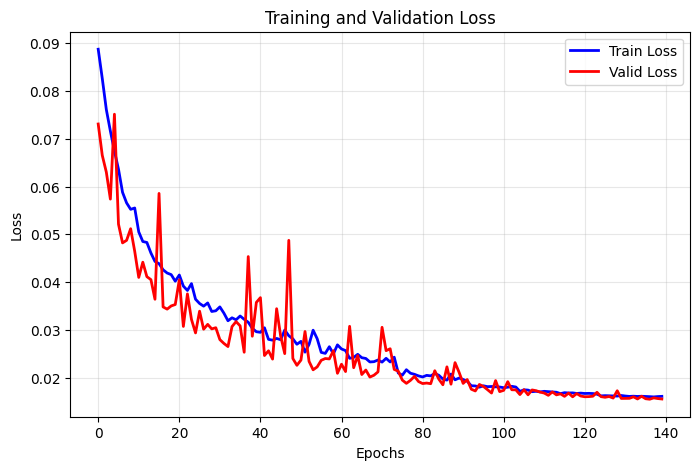

In [30]:
plot_history(history['train_loss'][10:], history['valid_loss'][10:])

#### Test pendulumenet

In [31]:
sample_idx = np.random.choice(config.TEST_SIZE)
sample_idx

544

In [32]:
# Choose a sample from the test set
pendulum_net.eval()
with torch.no_grad():
    observations, questions, params = test_dataset[sample_idx]
    observations = observations.unsqueeze(0).to(device)  # Add batch dimension
    questions = questions.unsqueeze(0).to(device)

    possible_answer, mean, logvar = pendulum_net(observations, questions)
    possible_answer = possible_answer.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
    observations = observations.squeeze().cpu().numpy()
    questions = questions.squeeze().cpu().numpy()
    L, b = params.numpy()

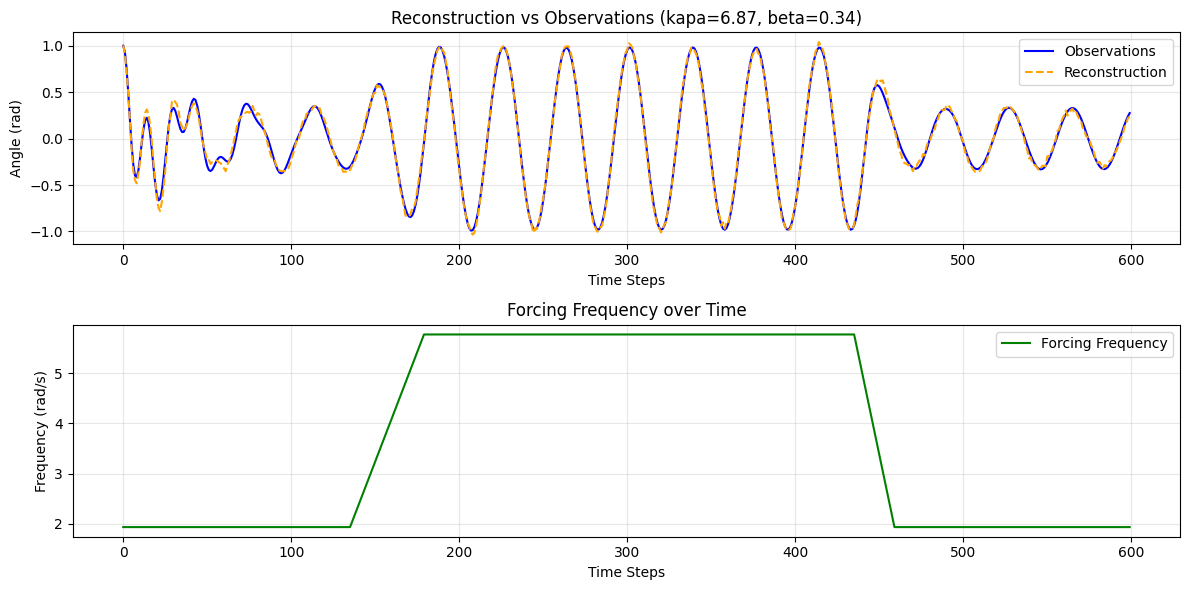

In [33]:
# Plot the results
# Fistly, plot the reconstruction and the observations
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(observations, label='Observations', color='blue')
plt.plot(possible_answer, label='Reconstruction', color='orange', linestyle='--')
plt.title(f'Reconstruction vs Observations (kapa={L:.2f}, beta={b:.2f})')
plt.xlabel('Time Steps')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(questions, label='Forcing Frequency', color='green')
plt.title('Forcing Frequency over Time')
plt.xlabel('Time Steps')
plt.ylabel('Frequency (rad/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

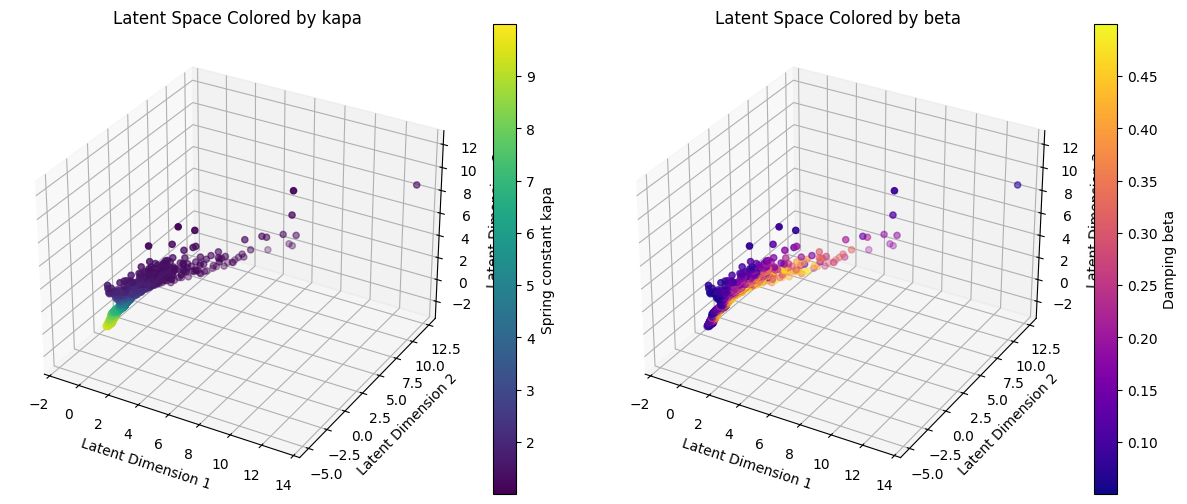

In [34]:
## Secondly, plot the latent space
all_means = []
all_params = []
pendulum_net.eval()
with torch.no_grad():
    for observations, questions, params in test_loader:
        observations = observations.to(device)
        questions = questions.to(device)
        mean, _ = pendulum_net.encoder(observations)
        all_means.append(mean.cpu().numpy())
        all_params.append(params.numpy())
all_means = np.concatenate(all_means, axis=0)
all_params = np.concatenate(all_params, axis=0)
L_values = all_params[:, 0]
b_values = all_params[:, 1]
latent_1 = all_means[:, 0]
latent_2 = all_means[:, 1]
latent_3 = all_means[:, 2]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=L_values, cmap='viridis')
fig.colorbar(p, ax=ax, label='Spring constant kapa')
ax.set_title('Latent Space Colored by kapa')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=b_values, cmap='plasma')
fig.colorbar(p, ax=ax, label='Damping beta')
ax.set_title('Latent Space Colored by beta')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()

In [35]:
print(pendulum_net)

PendulumNet(
  (encoder): SciNetEncoder(
    (layers): ModuleList(
      (0): Linear(in_features=600, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=10, bias=True)
    )
    (activations): ModuleList(
      (0-1): 2 x ELU(alpha=1.0)
    )
    (mean_layer): Linear(in_features=10, out_features=3, bias=True)
    (logvar_layer): Linear(in_features=10, out_features=3, bias=True)
  )
  (decoder): QuestionDecoder(
    (layers): ModuleList(
      (0): Linear(in_features=603, out_features=500, bias=True)
      (1): Linear(in_features=500, out_features=1000, bias=True)
      (2): Linear(in_features=1000, out_features=500, bias=True)
      (3): Linear(in_features=500, out_features=600, bias=True)
    )
    (activations): ModuleList(
      (0-2): 3 x ELU(alpha=1.0)
      (3): Identity()
    )
  )
)


In [36]:
# print trainable parameters
total_params = sum(p.numel() for p in pendulum_net.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1634726


### Plot Latent neurons activations vs physical parameters

In [37]:
def get_one_latent_activation(
    model: nn.Module, observation: np.array, question: np.array, device: torch.device = torch.device("cpu")
) -> np.array:
    """
    Get the latent activation for a single observation.

    Args:
        model (nn.Module): The trained model.
        observation (np.array): The input observation.
        device (torch.device, optional): The device to run the model on. Defaults to CPU.

    Returns:
        np.array: The latent activation.
    """
    torch.cuda.empty_cache()
    model.to(device).eval()
    observation_tensor = (torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device))
    #question_tensor = (torch.tensor(question, dtype=torch.float32).unsqueeze(0).to(device))
    latent_activations = []
    with torch.no_grad():
        mean, _ = model.encoder(observation_tensor)
        latent_activations.append(mean.cpu().numpy())
    return np.array(latent_activations)

In [38]:
def get_latent_activations(
    model: nn.Module,
    kapa_range: tuple,
    b_range: tuple,
    pixel_by_line: int = 50,
    device: torch.device = torch.device("cpu"),
) -> tuple[np.array]:
    """
    Get the latent activations for a grid of (kapa, b) values.

    Args:
        model (nn.Module): The trained model.
        kapa_range (tuple): Range of kapa values (min, max).
        b_range (tuple): Range of b values (min, max).
        pixel_by_line (int, optional): Number of points per axis. Defaults to 50.
        device (torch.device, optional): The device to run the model on. Defaults to CPU

    Returns:
        3-tuple containing:
            np.array: The grid of kapa values
            np.array: The grid of b values
            np.array: The latent activations for the grid of (kapa, b) values
    """
    # Create a grid of (kapa, b) values
    kapa_values = np.linspace(*kapa_range, pixel_by_line)
    b_values = np.linspace(*b_range, pixel_by_line)
    kapa_grid, b_grid = np.meshgrid(kapa_values, b_values)

    # Loop over the grid and get latent activations
    latent_activations = []
    for kapa in kapa_values:
        for beta in b_values:
            # Generate observation
            eps = 0
            trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
            trapezoidal_forcing_ranges = {
                "start_value": (1.0, 1.0),
                "end_value": (6.0, 6.0),
                "proportions": trapezoid_range,
            }

            beta_range = (beta, beta)
            kapa_range = (kapa, kapa)

            dataset = create_dataset(
                N_sample=1,
                maxtime=config.MAXTIME,
                n_timestep=config.TIMESTEPS,
                kapa_range=kapa_range,
                beta_range=beta_range,
                trapezoidal_forcing_values=trapezoidal_forcing_ranges,
                A_value=config.A_VALUE,
                omega_value=config.OMEGA_VALUE,
                theta0=config.THETA0,
                omega0=config.OMEGA0
            )

            observation = dataset[0]['angle']
            question = dataset[0]['forcing']

            # Find latent activation with encoder only
            latent_act = get_one_latent_activation(model, observation, question, device=device)
            latent_activations.append(latent_act)
    latents = np.array(latent_activations).reshape(pixel_by_line, pixel_by_line, -1)

    return kapa_grid, b_grid, latents

In [39]:
def plot_3d_latent_activations(
    kapa_grid: np.array,
    b_grid: np.array,
    latent_activations: np.array,
    save_path: str,
    shared_scale: bool = False,
) -> None:
    """ "
    Plot the latent activations in 3D for each latent dimension.

    Args:
        kapa_grid (np.array): The grid of kapa values.
        b_grid (np.array): The grid of b values.
        latent_activations (np.array): The latent activations for the grid of (kapa, b) values.
        save_path (str): Path to save the plot.
        shared_scale (bool, optional): Whether to use a shared z-axis scale for all plots. Defaults to False.

    Returns:
        None
        Figures are saved to the specified path.
    """
    latent_dim = latent_activations.shape[2]
    fig = plt.figure(figsize=(6 * latent_dim, 8))

    if shared_scale:
        z_min = np.min(latent_activations)
        z_max = np.max(latent_activations)
    else:
        z_min = z_max = None

    # Plot each latent dimension
    for i in range(latent_dim):
        ax = fig.add_subplot(1, latent_dim, i + 1, projection="3d")
        surf = ax.plot_surface(
            kapa_grid,
            b_grid,
            latent_activations[:, :, i],
            alpha=0.8,
            cmap="viridis",
            label=f"Latent {i+1}",
        )

        if shared_scale:
            ax.set_zlim(z_min, z_max)
        ax.set_xlabel(r"$\kappa$")
        ax.set_ylabel(r"$b$")
        ax.set_title(f"Latent Dimension {i+1}")
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    return None

In [40]:
kapa_range = config.KAPA_RANGE
b_range = config.BETA_RANGE

kapa_grid, b_grid, latent_activations = get_latent_activations(
    pendulum_net, kapa_range, b_range, device=device, pixel_by_line=20
)

print("Latent activations computed.")

100%|██████████| 1/1 [00:00<00:00, 28.82it/s]

Latent activations computed.


In [41]:
path = config.DIR_FIGURES / "latent_activations_3d_2.png"
plot_3d_latent_activations(
    kapa_grid, b_grid, latent_activations, save_path=path, shared_scale=True
)
print(f"Latent activations plotted. Saved at: {path}")

Latent activations plotted. Saved at: /home/ITER/brussel/Documents/ITER-physical-parameters-with-SciNet/results/figures/latent_activations_3d_2.png
